In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../../")

import numpy as np
from src.utils.visualize import plotMatrix

import matplotlib.pyplot as plt
# %matplotlib widget
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import mutual_information, Statevector, partial_trace, concurrence, entanglement_of_formation
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import CirculatorSNAILGate, ConversionGainSmushGate
from src.cost_function import BasicCostInverse, BasicCost, BasicReducedCost
from src.optimizer import TemplateOptimizer
import h5py

In [2]:
t= 1.0
duration_1q = 0.25

# # if using riswap
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [RiSwapGate], edge_params=[[(0,1), (1,2)]])
# basis_str = "riswap"

varg_offset = 2 #set to 4 if want to use phase, and change 0s to vargs in pp2 constructor below
pp2 =lambda *vargs: ConversionGainSmushGate(0,0 , vargs[0], vargs[1], vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp2], edge_params=[[(0,1)]], vz_only=True, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
basis_str = "CG2Q"

# varg_offset = 4
# pp3 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], vargs[2], vargs[3], vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp3], edge_params=[[(0,1)]], vz_only=True, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
# basis_str = "CG2Q+P"


basis.build(1)
basis.spanning_range = range(1,2)

#for all smush gates make bounds
bounds_1q = 4*np.pi
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, bounds_1q, -bounds_1q)

# manually set the gc, gg bounds
for el in basis.circuit.parameters:
    s_el = str(el)
    if s_el in [f"Q{varg_offset-2}", f"Q{1+varg_offset-2}", f"Q{22+varg_offset-2}", f"Q{23+varg_offset-2}", f"Q{44+varg_offset-2}", f"Q{45+varg_offset-2}"]: #XXX these need to be offset by varg_offset
        #basis.add_bound(s_el, .5, 0)
        basis.add_bound(s_el, 0.5*np.pi, 0) #XXX when using riswapgate should be 0.5, but when using ConversionGain should be np.pi/2 !!! BAD BAD BAD

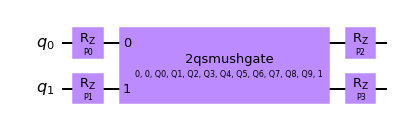

In [3]:
basis.circuit.draw(output='mpl')

In [4]:
# from src.sampler import HaarSample
# sampler = HaarSample(seed=0,n_samples=1)
# s = [s for s in sampler][0]
from src.utils.custom_gates import RiSwapGate, BerkeleyGate
from src.sampler import HaarSample, GateSample
sampler = GateSample(gate = RiSwapGate(1/2))
#sampler = GateSample(gate = BerkeleyGate())
s = [s for s in sampler][0]

In [5]:
# Here we want to save the best cost as a function of the success threshold
# success_thresholds = [0.99, 0.999, 0.9999, 0.99999, 0.999999]
# fidelities = [None]*len(success_thresholds)
# for k, success_threshold in enumerate(success_thresholds):
#     objective1 = BasicCost()

objective1 = BasicCost()

# keep trying until success_threshold converges:
i=0
LB = 0
UB = 1
current_cost = (UB + LB)/2
print(f"Starting cost = {current_cost}")

# keep trying until success_threshold converges:
while i == 0 or np.abs(current_cost - previous_cost) > 0.01:
    if not current_cost is None:
        basis.set_constraint(param_max_cost=current_cost)
        #pass
    #rebuild optimizer to refresh the updated f_basis obj
    #NOTE setting the success threshold low since SWAP is very hard to find exactly
    optimizer3 = TemplateOptimizer(basis=basis, objective=objective1, use_callback=True, override_fail=True, success_threshold = 1e-7, training_restarts=5)

    _ret3 = optimizer3.approximate_target_U(s)
    current_cost = basis.circuit_cost(_ret3.Xk)
    print(f"Iteration:{i}, Decomposition Result:{_ret3.loss_result}, Cost:{current_cost},")

    #search using 2 steps forward, 1 step back approach BAD
    # I want to do a binary search between 0 and 1.5 
    # if success, then set next cost to be current - LB / 2
    # if fail, then set next cost to be current + (UB - current) / 2
    
    if _ret3.success_label:
        ret3 = _ret3
        #fidelities[k] = ret3

        #success means can tighten the constraint
        previous_cost = current_cost
        current_cost = (current_cost + LB)/2
        print("Success, new cost:", current_cost)
        #update UB
        UB = previous_cost

    else:
        #fail means loosen the constraint
        previous_cost = current_cost
        current_cost = (current_cost + UB)/2
        print("Fail, new cost:", current_cost)
        #update LB
        LB = previous_cost

    i+=1

    # # save fidelities to h5 file
    # with h5py.File(f'swap_fidelities_{basis_str}.h5', 'a') as hf:
    #     #if dataset exists, delete it
    #     if f"success_{success_threshold}" in hf:
    #         del hf[f"success_{success_threshold}"]
    #     hf.create_dataset(f"success_{success_threshold}", data=fidelities[k])

INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Starting cost = 0.5


100%|██████████| 5/5 [03:26<00:00, 41.24s/it]
INFO:root:Cycle (k =1), Best Loss=0.030220479921396093
INFO:root:Overall Best Loss=0.030220479921396093
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.25, 0.09464621, 0.02177237)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:0, Decomposition Result:0.030220479921396093, Cost:0.5000000000000002,
Fail, new cost: 0.7500000000000001


100%|██████████| 5/5 [02:32<00:00, 30.46s/it]
INFO:root:Cycle (k =1), Best Loss=0.0026878926083095944
INFO:root:Overall Best Loss=0.0026878926083095944
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.7216686, 0.21289299, 1.192e-05)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:1, Decomposition Result:0.0026878926083095944, Cost:0.5566627938375677,
Fail, new cost: 0.7783313969187838


100%|██████████| 5/5 [00:59<00:00, 11.83s/it]
INFO:root:Cycle (k =1), Best Loss=0.018644086633890722
INFO:root:Overall Best Loss=0.018644086633890722
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.29265549, 0.14711023, 0.05244264)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:2, Decomposition Result:0.018644086633890722, Cost:0.5853109873559325,
Fail, new cost: 0.7926554936779662


100%|██████████| 5/5 [02:14<00:00, 26.87s/it]
INFO:root:Cycle (k =1), Best Loss=0.01870568043805454
INFO:root:Overall Best Loss=0.01870568043805454
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.28708753, 0.15228616, 0.0657475)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:3, Decomposition Result:0.01870568043805454, Cost:0.5741750635091454,
Fail, new cost: 0.7870875317545727


100%|██████████| 5/5 [02:18<00:00, 27.63s/it]
INFO:root:Cycle (k =1), Best Loss=0.025913525736539822
INFO:root:Overall Best Loss=0.025913525736539822
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.29940462, 0.12004889, 0.02452493)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:4, Decomposition Result:0.025913525736539822, Cost:0.5988092440206926,
Fail, new cost: 0.7994046220103463


100%|██████████| 5/5 [01:40<00:00, 20.01s/it]
INFO:root:Cycle (k =1), Best Loss=0.006278151850713787
INFO:root:Overall Best Loss=0.006278151850713787
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.27753763, 0.20217544, 0.04462338)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:5, Decomposition Result:0.006278151850713787, Cost:0.5550752574948592,
Fail, new cost: 0.7775376287474296


100%|██████████| 5/5 [02:15<00:00, 27.13s/it]
INFO:root:Cycle (k =1), Best Loss=0.008984418714040987
INFO:root:Overall Best Loss=0.008984418714040987
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.71114905, 0.1823047, 0.03477416)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:6, Decomposition Result:0.008984418714040987, Cost:0.5777019047220023,
Fail, new cost: 0.7888509523610012


100%|██████████| 5/5 [01:54<00:00, 22.88s/it]
INFO:root:Cycle (k =1), Best Loss=0.014187634101035407
INFO:root:Overall Best Loss=0.014187634101035407
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.29941148, 0.15480823, 0.00385117)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:7, Decomposition Result:0.014187634101035407, Cost:0.5988229670316232,
Fail, new cost: 0.7994114835158116


100%|██████████| 5/5 [01:51<00:00, 22.35s/it]
INFO:root:Cycle (k =1), Best Loss=0.007589076322090382
INFO:root:Overall Best Loss=0.007589076322090382
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.27901381, 0.19614964, 0.04903607)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:8, Decomposition Result:0.007589076322090382, Cost:0.5580276107987584,
Fail, new cost: 0.7790138053993791


100%|██████████| 5/5 [01:49<00:00, 22.00s/it]
INFO:root:Cycle (k =1), Best Loss=0.01454649721746748
INFO:root:Overall Best Loss=0.01454649721746748
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.29984862, 0.15357217, 0.00176186)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:9, Decomposition Result:0.01454649721746748, Cost:0.5996972396749842,
Fail, new cost: 0.7998486198374921


100%|██████████| 5/5 [02:06<00:00, 25.30s/it]
INFO:root:Cycle (k =1), Best Loss=0.01404921986860963
INFO:root:Overall Best Loss=0.01404921986860963
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.29874219, 0.15700427, 0.00631495)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:10, Decomposition Result:0.01404921986860963, Cost:0.5974843808911142,
Fail, new cost: 0.7987421904455572


100%|██████████| 5/5 [02:10<00:00, 26.08s/it]
INFO:root:Cycle (k =1), Best Loss=0.146447723818513
INFO:root:Overall Best Loss=0.146447723818513
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.0, 0.0, 0.0)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:11, Decomposition Result:0.146447723818513, Cost:1.4020427007701156e-17,
Fail, new cost: 0.5


100%|██████████| 5/5 [01:51<00:00, 22.38s/it]
INFO:root:Cycle (k =1), Best Loss=0.010056255756531352
INFO:root:Overall Best Loss=0.010056255756531352
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.75, 0.17343438, 0.0477323)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:12, Decomposition Result:0.010056255756531352, Cost:0.5,
Fail, new cost: 0.75


100%|██████████| 5/5 [02:18<00:00, 27.63s/it]
INFO:root:Cycle (k =1), Best Loss=0.0063237793207999715
INFO:root:Overall Best Loss=0.0063237793207999715
INFO:root:Fail: (0.25, 0.25, 0.0), Found: (0.27945012, 0.20023853, 0.04227622)
INFO:root:Begin search: (0.25, 0.25, 0.0)
INFO:root:Starting opt on template size 1


Iteration:13, Decomposition Result:0.0063237793207999715, Cost:0.5589002305390618,
Fail, new cost: 0.7794501152695309


 20%|██        | 1/5 [00:23<01:35, 23.85s/it]

In [ ]:
# load best from h5
with h5py.File(f'sqiswap_fidelity.h5', 'r') as hf:
    #save ret3
    loss = hf['loss'][0]
    Xk = hf['Xk'][:]
    cycles = hf['cycles'][0]
    cost = hf['cost'][0]

# build the circuit
print(cost, loss)
#show the result of training
basis.build(cycles)
circuit =basis.assign_Xk(Xk)
circuit.draw()

0.12500000000001749 0.0614742657534455


»
q_0: »
     »
q_1: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                   ├
«     │  2qsmushgate(-3.14166745223154,-3.53809451621603,1π/8,3.00304233737071e-7,-3.83726519138434,3.83698884485411,3.83610061462769,-3.83629951531048,1) │
«q_1: ┤1                                                                                                                                                   ├
«     └────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘